In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import grangercausalitytests
from tqdm import tqdm

# Data

In [2]:
access = gpd.read_file("./data/processed_data/ICU_access_measures/ICU_access_county.shp")
access.head()

,index,NAME,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,...,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021,geometry
0,48327,Menard,0.481450,0.504673,0.494921,0.359804,0.380861,0.416848,0.445366,0.463968,...,0.057078,0.055447,0.057775,0.058969,0.056747,0.050579,0.046795,0.044798,0.042296,"POLYGON ((-99.77120 30.71079, -99.78240 30.710..."
1,48189,Hale,2.661175,2.398550,2.288703,0.672046,0.550668,0.580442,0.673039,0.691939,...,0.007549,0.006805,0.006247,0.005544,0.004431,0.004738,0.004571,0.004513,0.003913,"POLYGON ((-101.73504 33.82864, -101.73507 33.8..."
2,48011,Armstrong,0.008839,0.008874,0.009701,0.009687,0.008540,0.009005,0.009563,0.009912,...,0.001716,0.001967,0.002158,0.002462,0.002360,0.002270,0.002396,0.002478,0.002131,"POLYGON ((-101.08728 35.02708, -101.08729 35.0..."
3,48057,Calhoun,2.364419,1.663282,1.490708,0.618558,0.560262,0.519041,0.482546,0.417936,...,0.138889,0.120955,0.109047,0.109674,0.100102,0.084663,0.076442,0.073078,0.062078,"POLYGON ((-96.35229 28.50953, -96.35241 28.508..."
4,48077,Clay,1.756416,1.993939,1.554681,0.504286,0.399408,0.381449,0.362439,0.333911,...,0.001702,0.002336,0.003988,0.003731,0.004190,0.003748,0.004242,0.005163,0.004003,"POLYGON ((-97.97784 33.81417, -97.97784 33.813..."


In [3]:
death = gpd.read_file("./data/processed_data/relationship/seven_day_ratio.shp")
death.head()

,index,NAME,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,...,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021,TSA,geometry
0,48327,Menard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,K,"POLYGON ((-99.77120 30.71079, -99.78240 30.710..."
1,48189,Hale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,125.0,...,71.428571,80.0,75.471698,59.701493,60.606061,32.786885,52.631579,104.166667,B,"POLYGON ((-101.73504 33.82864, -101.73507 33.8..."
2,48011,Armstrong,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,A,"POLYGON ((-101.08728 35.02708, -101.08729 35.0..."
3,48057,Calhoun,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,100.000000,100.000000,100.000000,S,"POLYGON ((-96.35229 28.50953, -96.35241 28.508..."
4,48077,Clay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,C,"POLYGON ((-97.97784 33.81417, -97.97784 33.813..."


# Pearson

In [4]:
pearson_dict = dict()
for ind in tqdm(access["index"], position=0):
    acc_ts = access.loc[access["index"] == ind].copy(deep=True)
    assert len(acc_ts) == 1
    acc_ts = acc_ts.drop(columns=["index", "NAME", "geometry"])
    acc_ts = acc_ts.T
    acc_ts.columns = ["access"]
    # print(type(acc_ts))
    # acc_ts.head()

    death_ts = death.loc[death["index"] == ind].copy(deep=True)
    assert len(death_ts) == 1
    death_ts = death_ts.drop(columns=["index", "NAME", "TSA", "geometry"])
    # print(list(death_ts.columns))
    death_ts = death_ts.T
    death_ts.columns = ["death"]
    # print(type(death_ts))
    # death_ts.head()

    # need to make the data stationary
    # https://stackoverflow.com/questions/51772493/understanding-output-from-statsmodels-grangercausalitytests
    # https://en.wikipedia.org/wiki/Granger_causality#Method
    #data = acc_ts.join(death_ts)
    #print(len(data))
    x = acc_ts["access"]
    y = death_ts["death"]
    pearr, pearp = pearsonr(x, y)
    pearson_dict[ind] = dict()
    pearson_dict[ind]["coef"] = pearr
    pearson_dict[ind]["pval"] = pearp

  0%|          | 0/254 [00:00<?, ?it/s]/home/dijkstra/.local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|██████████| 254/254 [00:01<00:00, 153.71it/s]


In [5]:
coefs = [pearson_dict[ind]["coef"] for ind in access["index"]]
pvals = [pearson_dict[ind]["pval"] for ind in access["index"]]
pearson_df = pd.DataFrame({"index": access["index"], "coefs": coefs, "pvals": pvals})
pearson_df.head()

,index,coefs,pvals
0,48327,-0.121403,0.003436
1,48189,-0.001198,0.977050
2,48011,0.080030,0.054273
3,48057,-0.046674,0.262175
4,48077,-0.031332,0.451760


In [6]:
pearson_gdf = access.copy(deep=True)
pearson_gdf = pearson_gdf.merge(pearson_df, on="index")
pearson_gdf.head()

,index,NAME,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,...,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021,geometry,coefs,pvals
0,48327,Menard,0.481450,0.504673,0.494921,0.359804,0.380861,0.416848,0.445366,0.463968,...,0.057775,0.058969,0.056747,0.050579,0.046795,0.044798,0.042296,"POLYGON ((-99.77120 30.71079, -99.78240 30.710...",-0.121403,0.003436
1,48189,Hale,2.661175,2.398550,2.288703,0.672046,0.550668,0.580442,0.673039,0.691939,...,0.006247,0.005544,0.004431,0.004738,0.004571,0.004513,0.003913,"POLYGON ((-101.73504 33.82864, -101.73507 33.8...",-0.001198,0.977050
2,48011,Armstrong,0.008839,0.008874,0.009701,0.009687,0.008540,0.009005,0.009563,0.009912,...,0.002158,0.002462,0.002360,0.002270,0.002396,0.002478,0.002131,"POLYGON ((-101.08728 35.02708, -101.08729 35.0...",0.080030,0.054273
3,48057,Calhoun,2.364419,1.663282,1.490708,0.618558,0.560262,0.519041,0.482546,0.417936,...,0.109047,0.109674,0.100102,0.084663,0.076442,0.073078,0.062078,"POLYGON ((-96.35229 28.50953, -96.35241 28.508...",-0.046674,0.262175
4,48077,Clay,1.756416,1.993939,1.554681,0.504286,0.399408,0.381449,0.362439,0.333911,...,0.003988,0.003731,0.004190,0.003748,0.004242,0.005163,0.004003,"POLYGON ((-97.97784 33.81417, -97.97784 33.813...",-0.031332,0.451760


<AxesSubplot:>

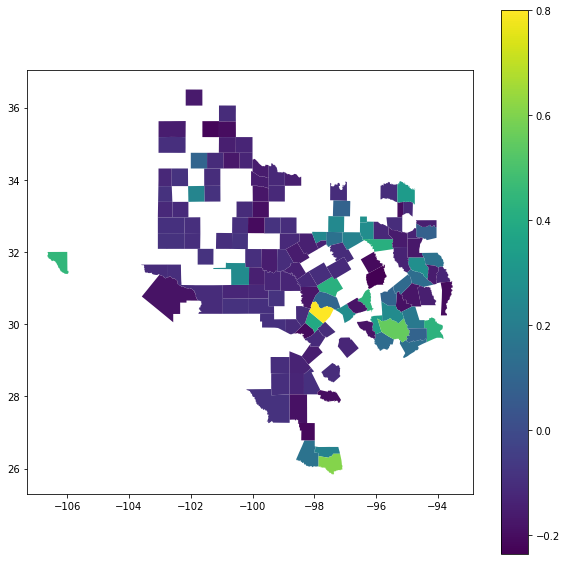

In [7]:
pearson_p05 = pearson_gdf[pearson_gdf["pvals"] <= 0.05]
pearson_p05.plot(column="coefs", figsize=(10, 10), legend=True)

# Spearman

In [8]:
spearman_dict = dict()
for ind in tqdm(access["index"], position=0):
    acc_ts = access.loc[access["index"] == ind].copy(deep=True)
    assert len(acc_ts) == 1
    acc_ts = acc_ts.drop(columns=["index", "NAME", "geometry"])
    acc_ts = acc_ts.T
    acc_ts.columns = ["access"]
    # print(type(acc_ts))
    # acc_ts.head()

    death_ts = death.loc[death["index"] == ind].copy(deep=True)
    assert len(death_ts) == 1
    death_ts = death_ts.drop(columns=["index", "NAME", "TSA", "geometry"])
    # print(list(death_ts.columns))
    death_ts = death_ts.T
    death_ts.columns = ["death"]
    # print(type(death_ts))
    # death_ts.head()

    # need to make the data stationary
    # https://stackoverflow.com/questions/51772493/understanding-output-from-statsmodels-grangercausalitytests
    # https://en.wikipedia.org/wiki/Granger_causality#Method
    #data = acc_ts.join(death_ts)
    #print(len(data))
    x = acc_ts["access"]
    y = death_ts["death"]
    pearr, pearp = spearmanr(x, y)
    spearman_dict[ind] = dict()
    spearman_dict[ind]["coef"] = pearr
    spearman_dict[ind]["pval"] = pearp

  0%|          | 0/254 [00:00<?, ?it/s]/home/dijkstra/.local/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
100%|██████████| 254/254 [00:02<00:00, 126.23it/s]


In [9]:
coefs = [spearman_dict[ind]["coef"] for ind in access["index"]]
pvals = [spearman_dict[ind]["pval"] for ind in access["index"]]
spearman_df = pd.DataFrame({"index": access["index"], "coefs": coefs, "pvals": pvals})
spearman_df.head()

,index,coefs,pvals
0,48327,-0.320837,2.500904e-15
1,48189,-0.190634,3.844360e-06
2,48011,-0.295428,3.989484e-13
3,48057,-0.175236,2.231744e-05
4,48077,-0.385072,6.637880e-22


In [10]:
spearman_gdf = access.copy(deep=True)
spearman_gdf = spearman_gdf.merge(spearman_df, on="index")
spearman_gdf.head()

,index,NAME,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,...,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021,geometry,coefs,pvals
0,48327,Menard,0.481450,0.504673,0.494921,0.359804,0.380861,0.416848,0.445366,0.463968,...,0.057775,0.058969,0.056747,0.050579,0.046795,0.044798,0.042296,"POLYGON ((-99.77120 30.71079, -99.78240 30.710...",-0.320837,2.500904e-15
1,48189,Hale,2.661175,2.398550,2.288703,0.672046,0.550668,0.580442,0.673039,0.691939,...,0.006247,0.005544,0.004431,0.004738,0.004571,0.004513,0.003913,"POLYGON ((-101.73504 33.82864, -101.73507 33.8...",-0.190634,3.844360e-06
2,48011,Armstrong,0.008839,0.008874,0.009701,0.009687,0.008540,0.009005,0.009563,0.009912,...,0.002158,0.002462,0.002360,0.002270,0.002396,0.002478,0.002131,"POLYGON ((-101.08728 35.02708, -101.08729 35.0...",-0.295428,3.989484e-13
3,48057,Calhoun,2.364419,1.663282,1.490708,0.618558,0.560262,0.519041,0.482546,0.417936,...,0.109047,0.109674,0.100102,0.084663,0.076442,0.073078,0.062078,"POLYGON ((-96.35229 28.50953, -96.35241 28.508...",-0.175236,2.231744e-05
4,48077,Clay,1.756416,1.993939,1.554681,0.504286,0.399408,0.381449,0.362439,0.333911,...,0.003988,0.003731,0.004190,0.003748,0.004242,0.005163,0.004003,"POLYGON ((-97.97784 33.81417, -97.97784 33.813...",-0.385072,6.637880e-22


<AxesSubplot:>

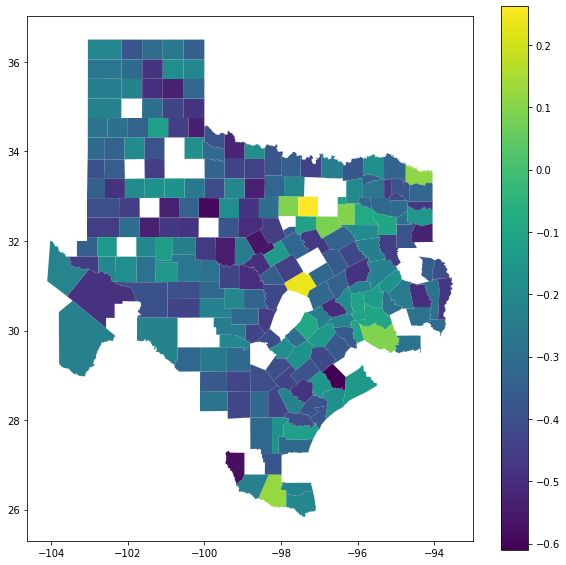

In [11]:
spearman_p05 = spearman_gdf[spearman_gdf["pvals"] <= 0.05]
spearman_p05.plot(column="coefs", figsize=(10, 10), legend=True)

# Granger Causality

In [12]:
def get_most_significant_lag(granger_result):
    best_lag = 0
    min_pval = 1
    for lag in granger_result.keys():
        pval = granger_result[lag][0]["ssr_ftest"][1]
        if pval < min_pval:
            best_lag = lag
            min_pval = pval
    return (best_lag, min_pval)

In [13]:
# the failures seem to be due to constant values
# i.e. if access is always zero, there is no
# way to calculate this

# seems the warnings are gone?
#import warnings
#warnings.filterwarnings("ignore")
# we need to look more deeply into the warnings
# the only thing I found was this, which likely doesn't apply:
# https://github.com/statsmodels/statsmodels/issues/7218

granger_results = {}
for ind in tqdm(access["index"], position=0):
    acc_ts = access.loc[access["index"] == ind].copy(deep=True)
    assert len(acc_ts) == 1
    acc_ts = acc_ts.drop(columns=["index", "NAME", "geometry"])
    acc_ts = acc_ts.T
    acc_ts.columns = ["access"]
    # print(type(acc_ts))
    # acc_ts.head()

    death_ts = death.loc[death["index"] == ind].copy(deep=True)
    assert len(death_ts) == 1
    death_ts = death_ts.drop(columns=["index", "NAME", "TSA", "geometry"])
    # print(list(death_ts.columns))
    death_ts = death_ts.T
    death_ts.columns = ["death"]
    # print(type(death_ts))
    # death_ts.head()

    # need to make the data stationary
    # https://stackoverflow.com/questions/51772493/understanding-output-from-statsmodels-grangercausalitytests
    # https://en.wikipedia.org/wiki/Granger_causality#Method
    #data = acc_ts.join(death_ts)
    #print(len(data))
    x = np.diff(acc_ts["access"])[1:]
    y = np.diff(death_ts["death"])[1:]
    data = pd.DataFrame({"access": x, "death": y})
    # data.head()
    try:
        result = grangercausalitytests(data, maxlag=30, verbose=False)
        lag, pval = get_most_significant_lag(result)
        granger_results[ind] = dict()
        granger_results[ind]["lag"] = lag
        granger_results[ind]["pval"] = pval
    except:
        print(f"{ind} failed")
        granger_results[ind] = dict()
        granger_results[ind]["lag"] = np.nan
        granger_results[ind]["pval"] = np.nan

  4%|▍         | 10/254 [00:05<02:13,  1.83it/s]

48247 failed


 28%|██▊       | 70/254 [00:37<01:20,  2.28it/s]

48137 failed


 33%|███▎      | 85/254 [00:44<01:29,  1.88it/s]

48385 failed


 35%|███▌      | 90/254 [00:46<01:29,  1.82it/s]

48345 failed


 38%|███▊      | 96/254 [00:50<01:35,  1.66it/s]

48377 failed


 48%|████▊     | 122/254 [01:02<00:56,  2.36it/s]

48229 failed


 55%|█████▌    | 140/254 [01:10<00:49,  2.30it/s]

48243 failed


 65%|██████▍   | 164/254 [01:21<00:48,  1.84it/s]

48443 failed


 78%|███████▊  | 199/254 [01:37<00:28,  1.95it/s]

48301 failed
48125 failed


 82%|████████▏ | 209/254 [01:41<00:20,  2.25it/s]

48269 failed


 84%|████████▍ | 213/254 [01:42<00:18,  2.25it/s]

48261 failed
48033 failed


100%|██████████| 254/254 [02:07<00:00,  1.99it/s]


In [14]:
lags = [granger_results[ind]["lag"] for ind in access["index"]]
pvals = [granger_results[ind]["pval"] for ind in access["index"]]
result_df = pd.DataFrame({"index": access["index"], "lag": lags, "pvals": pvals})
result_df.head()

,index,lag,pvals
0,48327,1.0,9.920743e-01
1,48189,28.0,6.798256e-52
2,48011,29.0,2.941820e-09
3,48057,2.0,9.128364e-01
4,48077,12.0,1.025372e-03


In [15]:
caus = access.copy(deep=True)
caus = caus.merge(result_df, on="index")
caus.head()

,index,NAME,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,...,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021,geometry,lag,pvals
0,48327,Menard,0.481450,0.504673,0.494921,0.359804,0.380861,0.416848,0.445366,0.463968,...,0.057775,0.058969,0.056747,0.050579,0.046795,0.044798,0.042296,"POLYGON ((-99.77120 30.71079, -99.78240 30.710...",1.0,9.920743e-01
1,48189,Hale,2.661175,2.398550,2.288703,0.672046,0.550668,0.580442,0.673039,0.691939,...,0.006247,0.005544,0.004431,0.004738,0.004571,0.004513,0.003913,"POLYGON ((-101.73504 33.82864, -101.73507 33.8...",28.0,6.798256e-52
2,48011,Armstrong,0.008839,0.008874,0.009701,0.009687,0.008540,0.009005,0.009563,0.009912,...,0.002158,0.002462,0.002360,0.002270,0.002396,0.002478,0.002131,"POLYGON ((-101.08728 35.02708, -101.08729 35.0...",29.0,2.941820e-09
3,48057,Calhoun,2.364419,1.663282,1.490708,0.618558,0.560262,0.519041,0.482546,0.417936,...,0.109047,0.109674,0.100102,0.084663,0.076442,0.073078,0.062078,"POLYGON ((-96.35229 28.50953, -96.35241 28.508...",2.0,9.128364e-01
4,48077,Clay,1.756416,1.993939,1.554681,0.504286,0.399408,0.381449,0.362439,0.333911,...,0.003988,0.003731,0.004190,0.003748,0.004242,0.005163,0.004003,"POLYGON ((-97.97784 33.81417, -97.97784 33.813...",12.0,1.025372e-03


<AxesSubplot:>

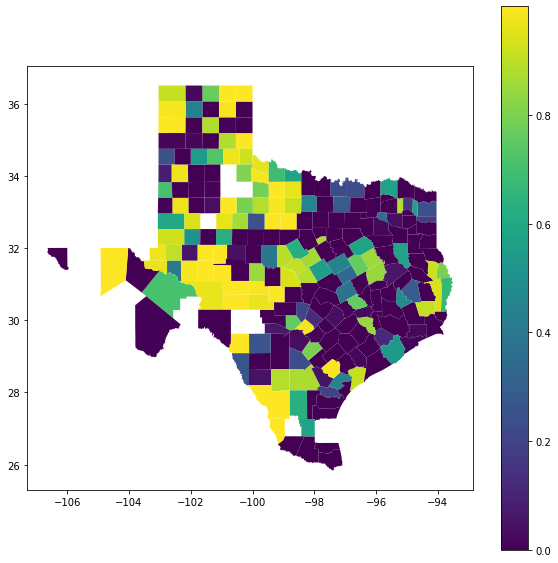

In [16]:
caus.plot(column="pvals", figsize=(10, 10), legend=True)

Text(0.5, 1.0, 'Lag with lowest p-value')

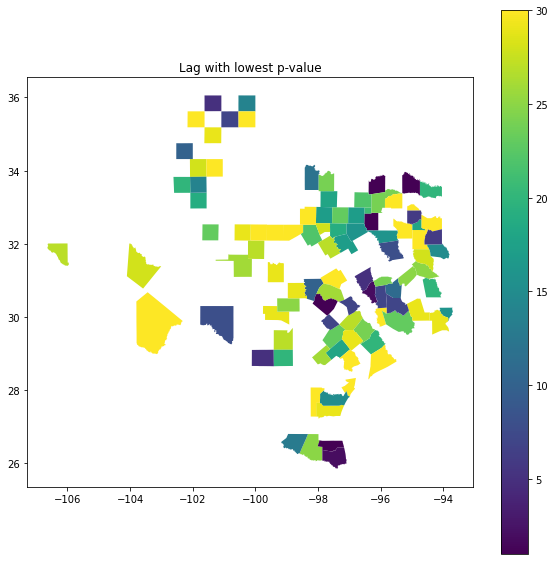

In [17]:
p01 = caus[caus["pvals"] <= 0.01]
p01.plot(column="lag", figsize=(10, 10), legend=True)
plt.title("Lag with lowest p-value")

<AxesSubplot:>

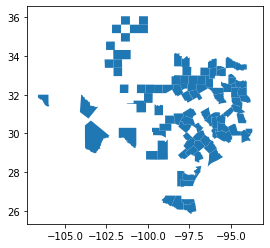

In [18]:
p01 = caus[caus["pvals"] <= 0.01]
p01.plot()